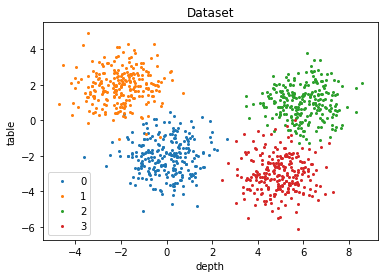

In [37]:
#@title Generate dataset
import pandas
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def scatter_clusters(X, y, color=True):
    for i in list(set(y)):
        cluster = [x for x, label in zip(X, y) if label == i]
        xs, ys = [x[0] for x in cluster], [x[1] for x in cluster]
        if color:
            plt.scatter(xs, ys, label=f"{i}", s=4)
        else:
            plt.scatter(xs, ys, label=f"{i}", cmap=plt.cm.Paired)
    plt.title("Dataset")
    plt.legend(loc='best')
    plt.xlabel("depth")
    plt.ylabel("table")
    plt.show()

df = make_blobs(1000, centers=[(0, -2), (-2, 2), (6, 1), (5, -3)])

X = df[0]
y = df[1]

scatter_clusters(X[:,[0, 1]], y)

Optimum clusters number is 4


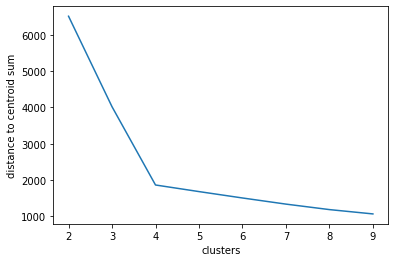

In [38]:
#@title Clusters number evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import log

ns = np.arange(2, 10)
ss = []

for n in ns:
    model = KMeans(n)
    y = model.fit_predict(X, None)
    score = model.score(X)
    ss.append(-score)
clusters_num = max([n + 3 for n, (y, x) in enumerate(zip(ss[1:], ss[:-1])) if y - x < -1000])
print(f"Optimum clusters number is {clusters_num}")
plt.plot(ns, ss)
plt.xlabel("clusters")
plt.ylabel("distance to centroid sum")
plt.show()

Silhoutte score: 0.589


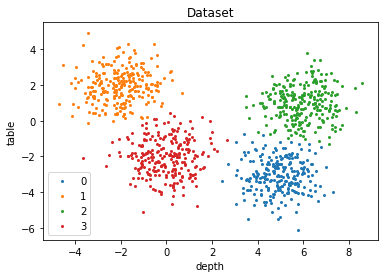

In [39]:
#@title Clustered dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

model = KMeans(clusters_num)
y = model.fit_predict(X, None)
score = silhouette_score(X, y)
print(f"Silhoutte score: {score:.3f}")
scatter_clusters(X[:,[0,1]], y)

Optimum eps is 0.719


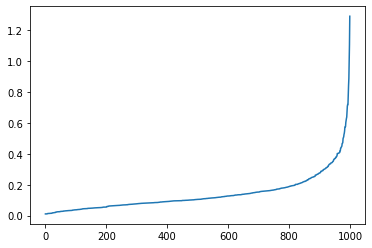

In [40]:
#@title Evaluation of optimum eps for DBSCAN
from sklearn.neighbors import NearestNeighbors
from math import sqrt

def cercle_circonscrit(T):
    (x1, y1), (x2, y2), (x3, y3) = T
    A = np.array([[x3-x1,y3-y1],[x3-x2,y3-y2]])
    Y = np.array([(x3**2 + y3**2 - x1**2 - y1**2),(x3**2+y3**2 - x2**2-y2**2)])
    if np.linalg.det(A) == 0:
        return 10 ** 80
    Ainv = np.linalg.inv(A)
    X = 0.5*np.dot(Ainv,Y)
    x,y = X[0],X[1]
    r = sqrt((x-x1)**2+(y-y1)**2)
    return r

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

max_curvature = -1
ind = -1
for i in range(len(distances) - 2):
    r = cercle_circonscrit(zip(range(i, i + 3), distances[i : i + 3]))
    curvature = 1 / r
    if curvature > max_curvature:
        max_curvature = curvature
        ind = i
epsilon = distances[ind]
print(f"Optimum eps is {epsilon:.3f}")

plt.plot(distances)
plt.show()

Optimum values for minpts are (minpts: score):
    19: 0.544
    20: 0.544
    12: 0.512
    4: 0.509


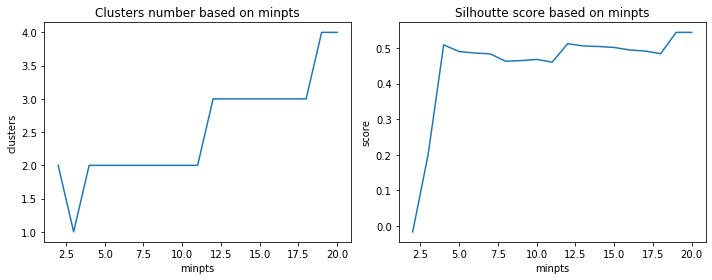

In [41]:
#@title Choosing optimum minpts
from sklearn.cluster import DBSCAN

ns = np.arange(2, 21)
cs = []
ss = []

for n in ns:
    db = DBSCAN(eps=epsilon, min_samples=n).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if len(set(labels)) == 1:
        score = 0
    else:
        score = silhouette_score(X, labels)

    cs.append(n_clusters)
    ss.append(score)

opt_n = sorted(zip(ns, ss), key=lambda x:-x[1])
print(f"Optimum values for minpts are (minpts: score):")
for i in range(4):
    print(f"    {opt_n[i][0]}: {opt_n[i][1]:.3f}")
minpts = opt_n[0][0]

plt.subplots(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Clusters number based on minpts")
plt.xlabel("minpts")
plt.ylabel("clusters")
plt.plot(ns, cs)

plt.subplot(1, 2, 2)
plt.title("Silhoutte score based on minpts")
plt.xlabel("minpts")
plt.ylabel("score")
plt.plot(ns, ss)

plt.tight_layout()
plt.show()

In [0]:
epsilon, minpts = 0.65, 18

In [43]:
#@title Processing DBSCAN with those parameters
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=epsilon, min_samples=minpts).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
score = silhouette_score(X, labels)

print(f'Estimated number of clusters: {n_clusters}')
print(f"Silhouette Coefficient: {score:.3f}")

Estimated number of clusters: 4
Silhouette Coefficient: 0.525


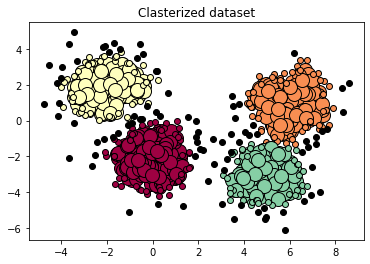

In [44]:
#@title DBSCAN clustering
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Clasterized dataset')
plt.show()